# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import statsmodels.api as sm
import seaborn as sns 
import lightgbm as lgb
import phik
from phik.report import plot_correlation_matrix
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score
from lightgbm import LGBMRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [4]:
sns.set()

*Изучим данные и обработаем их*

In [5]:
df = pd.read_csv('/datasets/autos.csv')
df.columns = df.columns.str.lower()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354369 non-null  object
 1   price              354369 non-null  int64 
 2   vehicletype        316879 non-null  object
 3   registrationyear   354369 non-null  int64 
 4   gearbox            334536 non-null  object
 5   power              354369 non-null  int64 
 6   model              334664 non-null  object
 7   kilometer          354369 non-null  int64 
 8   registrationmonth  354369 non-null  int64 
 9   fueltype           321474 non-null  object
 10  brand              354369 non-null  object
 11  repaired           283215 non-null  object
 12  datecreated        354369 non-null  object
 13  numberofpictures   354369 non-null  int64 
 14  postalcode         354369 non-null  int64 
 15  lastseen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
df.describe()

,price,registrationyear,power,kilometer,registrationmonth,numberofpictures,postalcode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


*Проверим дубликаты*

In [9]:
df.duplicated().sum()

4

In [10]:
df.drop_duplicates(inplace=True)

*У нас есть пустой и следовательно бесплозный столбец numberofpictures*

In [11]:
df['numberofpictures'].unique()

array([0])

*Рассмотрим признаки более внимательно. Начнем с целевого*

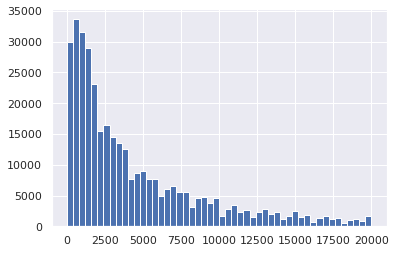

In [12]:
df['price'].hist(bins=50)
plt.show()

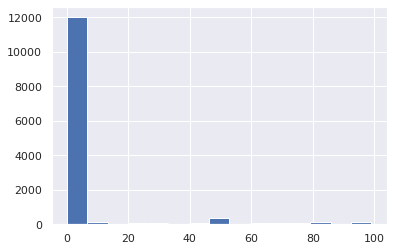

In [13]:
df['price'][df['price'] < 100].hist(bins=15)
plt.show()

*Из графика видно, что можно смело убирать данные с ценой меньше 50 евро, скорее всего они сдаются как металлолом, потому что утилизировать дороже.*

In [14]:
np.percentile(df['price'],3.5)

45.0

In [15]:
df = df[df['price'] >= 50]

*К сожалению это будет стоить 3.5% данных* 

<AxesSubplot:>

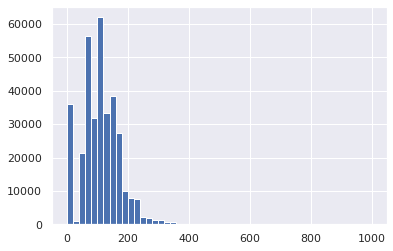

In [16]:
df['power'][df['power'] < 1000].hist(bins=50)

*В данных явно есть нестыковки, например, мощность в 20000 явный перебор. Поэтому отсечем все что выше 400 л.с., например, Лэнд Крузер, Чероки имею мощность 300-350, вдруг у кого-то еще и турбина. Если есть в выборке автобобили как Ferrari LaFerrari с 950 л.с., они будут только искревлять зависимость для популярных авто. Также у нас черезмерное количество маломощных авто, сделаем отсечку по 25 л.с., т.к. даже самая слабая Ока имеет под капотом 31 л.с.*

*Дальше, у нас есть минимальный год регистрации 1000, возможно, это действительно повозка Владимира Святославича, но отсечь новую минимальную планку для даты нужно. Также максимальный год 9999, отсечем до 2022 годом. И после построим гистограмму, чтобы узнать минимальный порог. Еще удалим столбец с количеством фото*

In [17]:
df = df.drop('numberofpictures', axis=1)

In [18]:
df = df[df['registrationyear'] < 2023]

<AxesSubplot:>

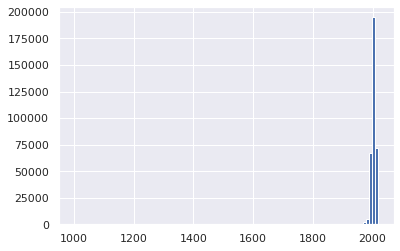

In [19]:
df['registrationyear'].hist(bins=100)

<AxesSubplot:>

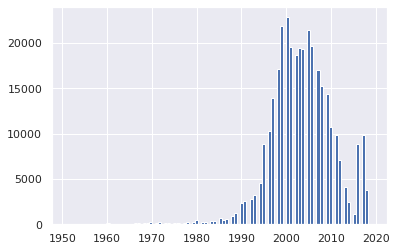

In [20]:
df['registrationyear'][df['registrationyear'] > 1950].hist(bins=100)

*Из графика видно, что нужный нам диапазон 1960-2019*

In [21]:
df = df[(df['registrationyear'] >= 1960) & (df['registrationyear'] < 2020)]

In [22]:
df.datecrawled = pd.to_datetime(df.datecrawled)

<AxesSubplot:>

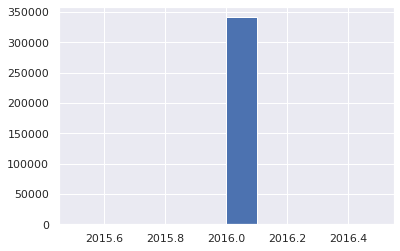

In [23]:
df.datecrawled.dt.year.hist()

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341550 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   datecrawled        341550 non-null  datetime64[ns]
 1   price              341550 non-null  int64         
 2   vehicletype        308727 non-null  object        
 3   registrationyear   341550 non-null  int64         
 4   gearbox            325058 non-null  object        
 5   power              341550 non-null  int64         
 6   model              324544 non-null  object        
 7   kilometer          341550 non-null  int64         
 8   registrationmonth  341550 non-null  int64         
 9   fueltype           312990 non-null  object        
 10  brand              341550 non-null  object        
 11  repaired           276896 non-null  object        
 12  datecreated        341550 non-null  object        
 13  postalcode         341550 non-null  int64   

In [25]:
df = df[(df['power'] > 24) & (df['power'] <= 400)]

*Изучим пропуски. Посчитаем сколько пропусков в процентах от общей выборки по каждому столбцу*

In [26]:
df.isna().sum() / len(df) * 100

datecrawled           0.000000
price                 0.000000
vehicletype           6.897772
registrationyear      0.000000
gearbox               1.947988
power                 0.000000
model                 3.951699
kilometer             0.000000
registrationmonth     0.000000
fueltype              6.377260
brand                 0.000000
repaired             15.249898
datecreated           0.000000
postalcode            0.000000
lastseen              0.000000
dtype: float64

*Модель сложно будет восстановить, поэтому удалим пропуски и столбцы которые не понадобятся*

In [27]:
df.dropna(subset=['model'], inplace=True)

*Данные не касающиеся ценообразования долой. Но сначала обратимся к почтовому индексу, как к марке гепозиции. Если речь идет о России первые три цифры - номер субъекта федерации. Поэтому оставим только первые три цифры*

<AxesSubplot:>

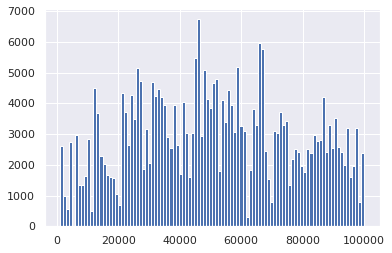

In [28]:
df['postalcode'].hist(bins=100)

In [29]:
def f(x):
    return int(str(x)[:3])

In [30]:
df['postalcode'] = df['postalcode'].apply(f)

<AxesSubplot:>

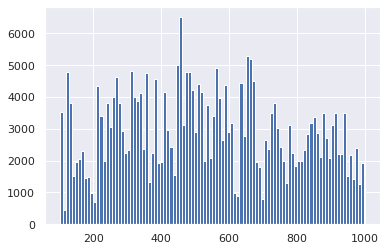

In [31]:
df['postalcode'].hist(bins=100)

In [32]:
df.drop(['datecrawled','lastseen','datecreated'],axis=1, inplace=True)

In [33]:
df.isna().sum() / len(df) * 100

price                 0.000000
vehicletype           6.236264
registrationyear      0.000000
gearbox               1.768090
power                 0.000000
model                 0.000000
kilometer             0.000000
registrationmonth     0.000000
fueltype              5.516538
brand                 0.000000
repaired             14.458345
postalcode            0.000000
dtype: float64

*Мы удалили около 5%, но прпоусков до сих пор достаточно много. Тепер удалим коробку передач так как это всего 1,7%, а критерий очень важный и заполнение с искажениями недопустимо. Далее заполним пропуски в типе топлива*

In [34]:
df.dropna(subset=['gearbox'],inplace=True)

In [35]:
df['fueltype'].value_counts()

petrol      181329
gasoline     86274
lpg           4440
cng            476
hybrid         180
other           68
electric        34
Name: fueltype, dtype: int64

*Заменим gasoline как petrol, ох уж эти терки между британцами и американцами.*

In [36]:
df.loc[df.fueltype == 'gasoline', 'fueltype'] = 'petrol'

In [37]:
df['fueltype'].value_counts(normalize=True)

petrol      0.980946
lpg         0.016276
cng         0.001745
hybrid      0.000660
other       0.000249
electric    0.000125
Name: fueltype, dtype: float64

*Видно, что более 98% всего типа бензина - petrol, поэтому заполним пропуски самым частым значением.*

In [38]:
 df['fueltype'].fillna( df['fueltype'].mode()[0],inplace=True)

In [39]:
df.isna().sum() / len(df) * 100

price                 0.000000
vehicletype           5.818716
registrationyear      0.000000
gearbox               0.000000
power                 0.000000
model                 0.000000
kilometer             0.000000
registrationmonth     0.000000
fueltype              0.000000
brand                 0.000000
repaired             13.922674
postalcode            0.000000
dtype: float64

*Попробовав закодировать категориальные признаки, можно увидеть, что их слишком много для onehot (для моего ноутбука). Поэтому будем использовать LabelEncoder хоть это и вызывает искажения в  отличии от бинарной кодировки. А для параметра битая/небитая заменим пропуски на unkown, так параметр очень важен.*

In [40]:
df['repaired'].fillna('unknown',inplace=True)

*Разделим данные на признаки и цель*

In [41]:
features = df.drop('price', axis=1)
target = df['price']

*Заменим пропуски в типе авто как 'unknown'*

In [42]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287847 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   vehicletype        271098 non-null  object
 1   registrationyear   287847 non-null  int64 
 2   gearbox            287847 non-null  object
 3   power              287847 non-null  int64 
 4   model              287847 non-null  object
 5   kilometer          287847 non-null  int64 
 6   registrationmonth  287847 non-null  int64 
 7   fueltype           287847 non-null  object
 8   brand              287847 non-null  object
 9   repaired           287847 non-null  object
 10  postalcode         287847 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 26.4+ MB


In [43]:
features.loc[features.vehicletype.isna(),'vehicletype'] = 'unknown'

In [44]:
feature_train, feature_valid, target_train, target_valid = train_test_split(features,
                                                                          target,
                                                                          test_size=.4,
                                                                          random_state=123
                                                                          )
feature_test, feature_valid, target_test, target_valid = train_test_split(feature_valid,
                                                                          target_valid,
                                                                          test_size=.5,
                                                                          random_state=123
                                                                          )

In [45]:
column = ['vehicletype','gearbox','model','fueltype','brand','repaired']
oe = OrdinalEncoder()
feature_train[column] = oe.fit_transform(feature_train[column])
feature_valid[column] = oe.transform(feature_valid[column])
feature_test[column] = oe.transform(feature_test[column])

/tmp/ipykernel_31/906140372.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_train[column] = oe.fit_transform(feature_train[column])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [46]:
feature_train = feature_train.reset_index(drop=True)
target_train = target_train.reset_index(drop=True)

In [47]:
target_df = pd.DataFrame(data=target_train,columns=['price'])

*Проверим данные на наличие аномалий.*

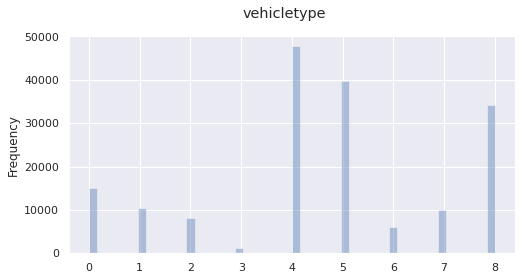

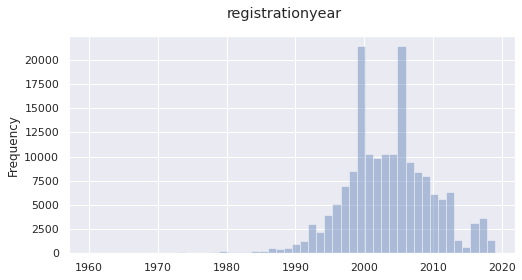

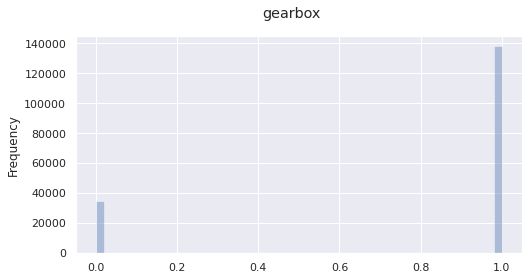

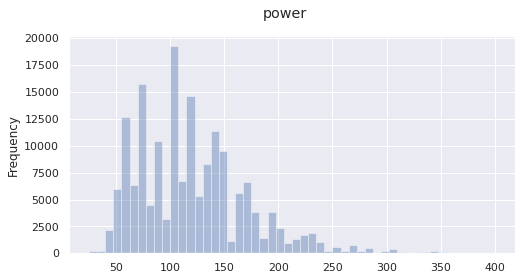

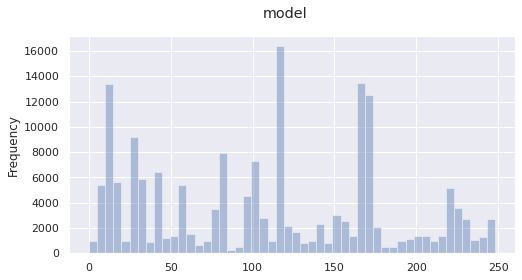

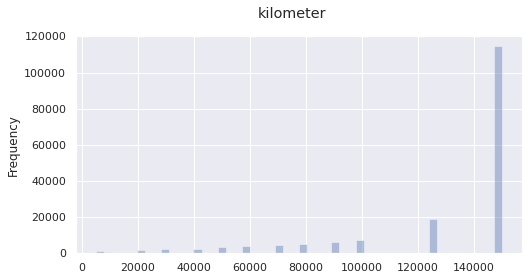

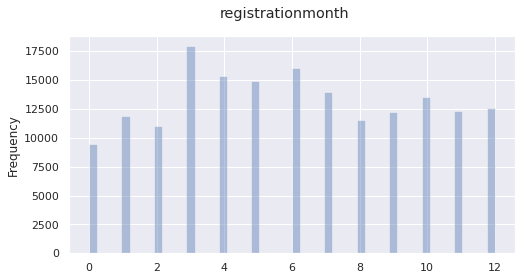

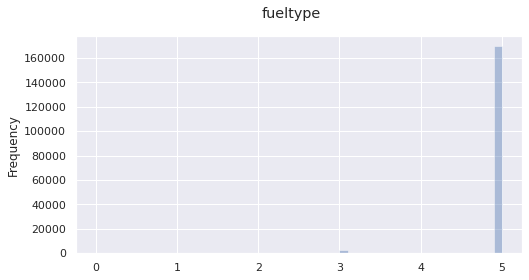

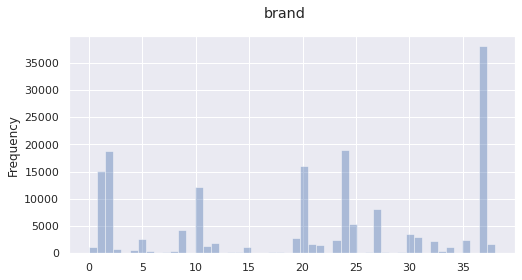

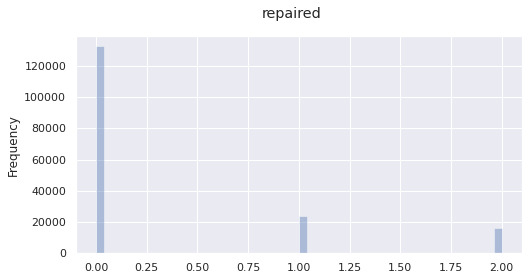

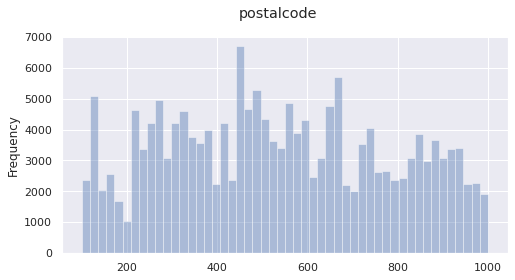

In [48]:
for column in feature_train.columns: 
    fig, axes = plt.subplots(1, 1, figsize=(8, 4))
    plt.suptitle(column)
    feature_train[column].plot(kind="hist",bins=50, color='b', alpha=0.4,ax=axes)
    plt.show()

interval columns not set, guessing: ['vehicletype', 'registrationyear', 'gearbox', 'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand', 'repaired', 'postalcode', 'price']


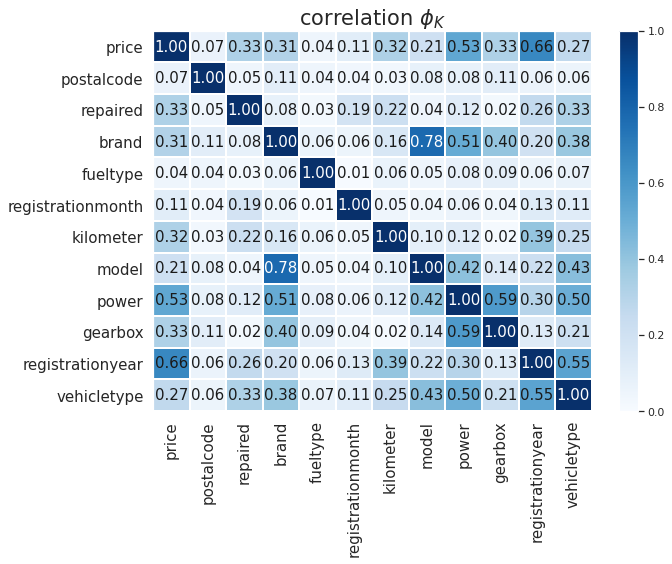

In [49]:
phik_overview = pd.concat([feature_train,target_df],axis=1).phik_matrix()

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(10, 8))
plt.tight_layout()

*Матрица корреляций показывает, что nип топлива, почтовый индек почти не коррелируют с ценой, поэтому удалим и их*

In [50]:
feature_train.drop(['fueltype','postalcode'],axis=1, inplace=True)
feature_valid.drop(['fueltype','postalcode'],axis=1, inplace=True)
feature_test.drop(['fueltype','postalcode'],axis=1, inplace=True)

In [51]:
(feature_train.shape[0] + feature_test.shape[0] + feature_valid.shape[0])/ 354369 * 100

81.22804195626593

**Вывод: в ходе обработки данных мы заполнили пропуски, где это возможно, и удалили некорректные данные. В итоге мы имеем дело с 81% от первоначальной совокупности, что стало результатом чистки данных. В целом данные подготовлены, из оставшихся аномалий стоит подчеркнуть странное распределение в годе регистрации - пики в 2000 и 2005 году.**

*Масштабируем признаки*

In [52]:
feature_train.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,brand,repaired
0,4.0,2007,0.0,231,15.0,150000,1,2.0,0.0
1,5.0,2004,1.0,60,128.0,80000,4,10.0,0.0
2,2.0,2001,0.0,163,59.0,150000,5,20.0,0.0
3,5.0,1992,1.0,45,173.0,20000,8,37.0,2.0
4,4.0,2000,1.0,150,15.0,150000,10,2.0,0.0


In [53]:
columns = ['vehicletype','registrationyear','power','model','kilometer','brand','repaired','registrationmonth'] 
scale = MinMaxScaler()
scale.fit(feature_train[columns])
feature_train[columns] = scale.transform(feature_train[columns])

In [54]:
feature_train.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,brand,repaired
0,0.500,0.796610,0.0,0.549333,0.060484,1.000000,0.083333,0.052632,0.0
1,0.625,0.745763,1.0,0.093333,0.516129,0.517241,0.333333,0.263158,0.0
2,0.250,0.694915,0.0,0.368000,0.237903,1.000000,0.416667,0.526316,0.0
3,0.625,0.542373,1.0,0.053333,0.697581,0.103448,0.666667,0.973684,1.0
4,0.500,0.677966,1.0,0.333333,0.060484,1.000000,0.833333,0.052632,0.0


In [55]:
feature_valid[columns] = scale.transform(feature_valid[columns])
feature_test[columns] = scale.transform(feature_test[columns])

## Обучение моделей

*По условию задачи метрика исслоедования - RMSE, объявим функцию*

In [56]:
def RMSE(test, predict):
    return round(mean_squared_error(test, predict)**.5, 3)

*Начнем с самого простого* **линейного регрессора**

In [57]:
%%time
model_lr = LinearRegression()
model_lr.fit(feature_train, target_train)

CPU times: user 36.6 ms, sys: 12.5 ms, total: 49.1 ms
Wall time: 44.9 ms


LinearRegression()

In [58]:
%%time
predict_lr = model_lr.predict(feature_valid)

CPU times: user 4.71 ms, sys: 26.9 ms, total: 31.6 ms
Wall time: 13.1 ms


In [59]:
RMSE(predict_lr,target_valid)

2983.742

*Рассмотрим применение* **случайного леса**

In [60]:
%%time
model_rf = RandomForestRegressor(random_state=123, n_estimators=70)
model_rf.fit(feature_train, target_train)

CPU times: user 34.4 s, sys: 539 ms, total: 35 s
Wall time: 35 s


RandomForestRegressor(n_estimators=70, random_state=123)

In [61]:
%%time
pred_rf=model_rf.predict(feature_valid)

CPU times: user 1.72 s, sys: 3.8 ms, total: 1.73 s
Wall time: 1.74 s


In [62]:
RMSE(pred_rf,target_valid)

1590.534

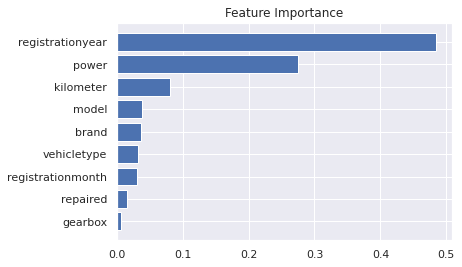

In [63]:
sort = model_rf.feature_importances_.argsort()
plt.barh(feature_train.columns[sort], model_rf.feature_importances_[sort])
plt.title("Feature Importance")
plt.show()

*Приступим к* **LightGMB**

In [64]:
%%time
model_lgb = LGBMRegressor(n_estimators=70, random_state=123, objective='RMSE')
model_lgb.fit(feature_train, target_train)

CPU times: user 4min 21s, sys: 3.05 s, total: 4min 24s
Wall time: 4min 26s


LGBMRegressor(n_estimators=70, objective='RMSE', random_state=123)

In [65]:
%%time
pred_lgb=model_lgb.predict(feature_valid)

CPU times: user 384 ms, sys: 2.81 ms, total: 387 ms
Wall time: 390 ms


In [66]:
RMSE(pred_lgb,target_valid)

1719.154

In [67]:
%%time
model_lgb = LGBMRegressor(n_estimators=200, random_state=123, objective='RMSE')
model_lgb.fit(feature_train, target_train)

CPU times: user 4min 39s, sys: 2.36 s, total: 4min 41s
Wall time: 4min 43s


LGBMRegressor(n_estimators=200, objective='RMSE', random_state=123)

In [68]:
%%time
pred_lgb=model_lgb.predict(feature_valid)

CPU times: user 861 ms, sys: 0 ns, total: 861 ms
Wall time: 904 ms


In [69]:
RMSE(pred_lgb,target_valid)

1621.944

In [70]:
train_dataset = lgb.Dataset(feature_train, target_train)
valid_dataset = lgb.Dataset(feature_valid, target_valid, reference=train_dataset)

In [71]:
%%time
param = {'objective': 'rmse','metric': 'l2','max_depth':40,"random_state": 123,"learning_rate":0.1}
booster = lgb.train(param,
                    train_dataset,
                    num_boost_round=1000,
                    valid_sets=[train_dataset, valid_dataset],
                    verbose_eval=100)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.472051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 593
[LightGBM] [Info] Number of data points in the train set: 172708, number of used features: 9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 4904.779495
[100]	training's l2: 2.72319e+06	valid_1's l2: 2.82047e+06
[200]	training's l2: 2.44372e+06	valid_1's l2: 2.6307e+06
[300]	training's l2: 2.28385e+06	valid_1's l2: 2.53952e+06
[400]	training's l2: 2.17184e+06	valid_1's l2: 2.48628e+06
[500]	training's l2: 2.08309e+06	valid_1's l2: 2.44848e+06
[600]	training's l2: 2.01063e+06	va

In [72]:
%%time
pred_booster=booster.predict(feature_valid)

CPU times: user 4.88 s, sys: 0 ns, total: 4.88 s
Wall time: 4.89 s


In [73]:
RMSE(pred_booster,target_valid)

1532.947

## Анализ моделей

*По условию задачи критерии, которые важны заказчику:*
- качество предсказания;
- время обучения модели;
- время предсказания модели.


*Как и ожидалось наиболее точная модель LightGMB c RMSE = 1532, но потребовало она больше всего времени более 7 минут на обучение и 5 c на предсказание из LGMB. Случайный лес показал примерно такой же результат 1590 за 34 с. Однако нужным параметром выбора модели является сочетание скорости и точности, поэтому выбор остановим на модели случайного леса.*

*Проведем тест*

In [75]:
%%time
RMSE(model_rf.predict(feature_test),target_test)

CPU times: user 1.75 s, sys: 0 ns, total: 1.75 s
Wall time: 1.75 s


1602.878

*Тест показал близкий к валидационной выборке результат, что говорит о том, что нага модель не переобучилась, показывает необходимое качество модели и скорость*